# BirdCLEF - Genkend fugle baseret på deres sang og kald

In [1]:
!pip install -Uqq fastbook
import fastbook
#fastbook.setup_book()

     |████████████████████████████████| 727kB 25.3MB/s 
     |████████████████████████████████| 204kB 44.0MB/s 
     |████████████████████████████████| 1.2MB 37.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -u "/content/drive/My Drive/Deep/FocusedBirds.zip" -d "/content/drive/My Drive/Deep/Birdsounds"
#!unzip -u "/content/drive/My Drive/Deep/TrainImages.zip" -d "/content/drive/My Drive/Deep/Birdsounds"
#!unzip -u "/content/drive/My Drive/Deep/Bird500.zip" -d "/content/drive/My Drive/Deep/Birdsounds/train_short_audio"

In [3]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import shutil, math, os
from fastai.vision.all import *

In [4]:
root = '/content/drive/My Drive/Deep/'
audio_path = root + 'Birdsounds/train_short_audio/Bird500/'
image_path = root + 'Images/'
sample_path = image_path +'sample_images'

In [5]:
meta_df = pd.read_csv(root + 'train_metadata.csv')
meta_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.5,07:50,https://www.xeno-canto.org/129981


Dataen til dette projekt kommer fra en konkurrence på kaggle. Dataen blev udleveret som lydfiler med optagelser af en til flere fugle og med en csv fil med metadata som blandt andet inderholder den primære fugl og sekundærer fugle der også fremgår i klippet.

Da der er alt for mange forskellige fugle til at det kan gøres på en ordentlig måde har jeg valgt at reducerer antallet af labels til 12 fugle, hvilket er de 12 hvor af der var flest optagelser.

For at der kan laves en klassifikation på lydklippene skal de først omdannes til billeder. For at gøre dette plottede jeg dem som deres spektogrammer med et python modul der hedder librosa. De plots gemmes så som png filer. 

In [ ]:
for folder in os.listdir(audio_path):
  print(folder)
  for recording in os.listdir(audio_path + folder):
    filepath = audio_path + folder + "/" + recording
    filename = recording.split('.')[0]

    imagename = root + f'Images/{filename}.png'
    if os.path.exists(imagename) : continue
    sig, rate = librosa.load(filepath, sr=32000, offset=0, duration=10)

    # First, compute the spectrogram using the "short-time Fourier transform" (stft)
    spec = librosa.stft(sig)

    # Scale the amplitudes according to the decibel scale
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(spec_db, 
                            sr=32000, 
                            x_axis='time', 
                            y_axis='hz', 
                            cmap=plt.get_cmap('viridis'))
    plt.savefig(imagename)
    plt.clf()
    plt.close('all')

Det resulterede i over 5000 billeder hvilket gjorde træningen utroligt langsom, så for at gøre processen en anelse hurtigere lavede jeg er et tilfældigt trænings sæt af 50 billeder pr fugl for også at holde det balanceret.

Dernæst sikre jeg mig en liste over fugle der er billed filer af for at de labels kan bruges senere.

In [6]:
converted_images = [i.split('.')[0]+'.ogg' for i in os.listdir(image_path)]
converted_images_df = meta_df[meta_df.filename.isin(converted_images)]
converted_labels = converted_images_df.primary_label.values[0]

Jeg skal bruge en metode til at få fat i y værdierne, fuglens navn, for at kunne lære hvilket kald kommer fra hvilken fugl. Det er i meta data filen og kan trækkes herfra. De sekundære labels er dog ikke en liste men desværre en string der ligner en liste. Strengen kan heldigvis let skilles ad.

In [7]:
def get_bird_label(file):
    file = str(file.parts[-1])
    file = file.split(' ')[0]
    filename = file.split('.')[0] + '.ogg'
    row = meta_df[meta_df['filename'] == filename]
    bird_label = [row['primary_label'].values[0]]
    secondaries = row.secondary_labels.values[0]
    secondaries.replace('[', '')
    secondaries.replace(']', '')
    for label in secondaries.split(','):
      if label not in converted_labels: continue
      bird_label.append(label)
      print(bird_label)
    return bird_label

Jeg bruger så en DataBlock til at samle metoder for at behandle og transformere dataen til når den skal bruges.

In [8]:
birds = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_bird_label,
    item_tfms=RandomResizedCrop(128))

Jeg omdanner den så til en dataloader og giver den stigen til min data.

In [9]:
dls = birds.dataloaders(image_path)

Da det er her er planen at bruge billeder til at klassificere lyd giver det bedst mening at bruge et Convolutional Neural Network (CNN) da disse er de bedste til analyse af billeder. Det gør de ved at trække features ud af billeder gennem et utal af filtre. Hvert enkelt filter udtrækker hver især en bid af information, som bliver mere og mere specifikke for hvert lag. De tidligste lag finder ting som lodrette og vandrette linjer, nogle af dem i midten finder ting som hjørner og cirkler, mens de sidste lag kan finde ting som kan gå fra kropsdele helt op til hele objekter.

Hertil bruges resnet18 som er et residualt net med 18 skjulte lag. Det er en pretrained model som bruges her til transfer learning. Transfer Learning er en måde hvorpå man kan reducere tiden det tager at træne sin model, og reducere mængden af data i forhold til hvad man før har behøvet. Det kan man da modellen i forvejen har lært sig at udtrække de basale former og mønstre og derfor kun skal tilpasses til den nye data. Den gamle model kaldes for kroppen, og den nye model bliver til et nyt hoved til kroppen.

In [10]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.02)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Da vi nu bruger transfer learning skal vi tilpasse vores krop og hoved til hinanden. Der er to forskellige metoder til at gøre dette: Fit og Fine Tune. Fit tager kroppen og prøver at træne videre og tilpasse både kroppen og hovedet til at arbejde med den nye data. Dette kan desværre ødelægge alt hvad der har været gjort på forhånd i den trænede model. Fine Tune på den anden side tilpasser kun lidt og træner kun hovedet der derfor ikke generer kroppen.

For at forbedre både træningstiden og resultatet deraf gør jeg brug af learning rate finder. Den løber igennem dataen og finder en funktion der beskriver udviklingen for modellens loss. Den outputter så to værdier, der hvor loss ændrer sig mest drastisk og der hvor loss ændrer sig mindst. Jeg bruger så der hvor den ændrer sig mest som min learning rate.

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.455330,0.328733,0.437266,10:19


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.252473,0.282650,0.539995,14:33
1,0.223416,0.254896,0.550762,14:07
2,0.193182,0.221853,0.489299,14:01
3,0.161605,0.208035,0.596241,14:20


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.252473,0.282650,0.539995,14:33
1,0.223416,0.254896,0.550762,14:07
2,0.193182,0.221853,0.489299,14:01
3,0.161605,0.208035,0.596241,14:20
4,0.145195,0.197106,0.643593,14:23


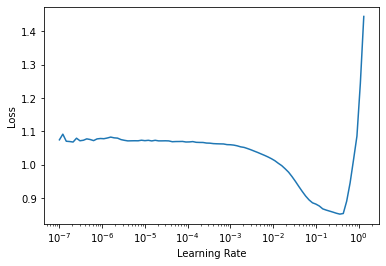

In [11]:
lr_min, lr_steep = learn.lr_find()
learn.fine_tune(5, base_lr=lr_steep)

In [12]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136180,0.196756,0.630284,14:14


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133849,0.197100,0.636437,14:35
1,0.132857,0.193359,0.656501,13:55
2,0.128305,0.197004,0.662319,13:44
3,0.122739,0.190228,0.650950,14:01
4,0.121430,0.191938,0.664660,13:41


In [13]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,norcar,spotow,"tensor([1.8487e-05, 5.1337e-06, 2.4346e-04, 1.0534e-05, 9.9729e-06, 4.6839e-05, 4.4338e-03, 3.2758e-04, 1.3420e-05, 2.7362e-03, 1.5870e-07, 9.9136e-01])",1.0651806592941284
1,houspa,redcro,"tensor([1.7131e-04, 1.4064e-05, 1.7537e-04, 9.2958e-06, 9.9930e-05, 7.0141e-04, 1.0403e-03, 2.5714e-04, 9.9472e-01, 1.6941e-03, 4.7950e-05, 1.7953e-04])",1.0424740314483643
2,houspa,redcro,"tensor([6.1904e-04, 1.5720e-04, 5.4421e-04, 1.9564e-04, 1.5968e-04, 2.9009e-03, 2.5410e-03, 2.0348e-03, 9.6021e-01, 3.6288e-02, 1.2944e-03, 1.0005e-03])",0.7593716979026794
3,spotow,eursta,"tensor([0.0318, 0.0013, 0.0057, 0.8055, 0.0094, 0.0180, 0.0782, 0.0011, 0.0056, 0.0036, 0.0014, 0.0012])",0.7120441794395447
4,houwre,eursta,"tensor([2.2890e-02, 8.1993e-04, 2.3735e-02, 9.1993e-01, 1.7007e-03, 3.7362e-03, 2.6626e-03, 5.6148e-04, 5.9111e-03, 1.0902e-02, 6.0504e-03, 2.2693e-04])",0.7108751535415649
5,houwre,gbwwre1,"tensor([9.3264e-04, 9.6221e-04, 1.4494e-03, 8.0620e-03, 9.7863e-01, 2.1319e-04, 1.0328e-02, 6.9324e-04, 1.5189e-03, 1.2304e-03, 4.2982e-05, 6.3124e-04])",0.7028728723526001
6,norcar,houwre,"tensor([2.3141e-03, 7.6430e-04, 1.0530e-02, 7.6362e-03, 1.2194e-02, 3.3244e-03, 8.9859e-01, 2.4534e-03, 2.5910e-03, 8.1082e-02, 7.6025e-05, 2.9810e-03])",0.7021654844284058
7,houspa,redcro,"tensor([1.5978e-03, 2.3597e-04, 9.9661e-04, 4.1407e-04, 9.3994e-04, 5.1396e-03, 1.1961e-02, 1.6679e-03, 9.5150e-01, 2.4191e-02, 5.7479e-04, 1.2113e-03])",0.6951014399528503
8,spotow,eursta,"tensor([0.2765, 0.0027, 0.0263, 0.6921, 0.0070, 0.0041, 0.0085, 0.0019, 0.0230, 0.0129, 0.0087, 0.0016])",0.6703795194625854
9,spotow,eursta,"tensor([0.0893, 0.0039, 0.1854, 0.5698, 0.0269, 0.0072, 0.0113, 0.0020, 0.0129, 0.0087, 0.0032, 0.0011])",0.667083203792572


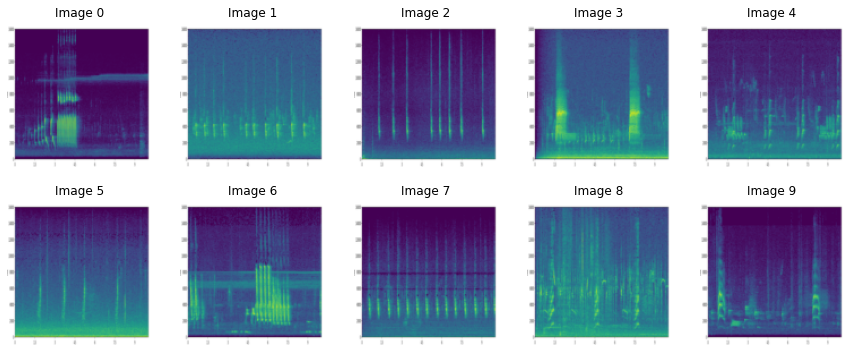

In [15]:
interp.plot_top_losses(10, nrows=2)

Modellen har desværre klaret sig så dårligt at det ville give meget lidt værdi at prøve at bruge den til at lave predictions, da det kun ville være lidt bedre end at gætte sig frem selv. Det er ikke at sige at den ikke ville kunne forbedres til at punkt hvor den ville kunne bruges i produktion. Eksempelvist ville en bedre loss function potentielt kunne give bedre resultater, eller tilsvarende for en bedre eller mere specifik learner. Der er desværre bare gået for meget tid med at optimere på modeller og data behandling til at disse muligheder har haft deres chance.